In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import os

torch.manual_seed(1)
torch.set_float32_matmul_precision('high')
default_type = torch.get_default_dtype()

cuda = torch.device("cuda")
torch.cuda.is_available()

True

***
### Preprocessing data

In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


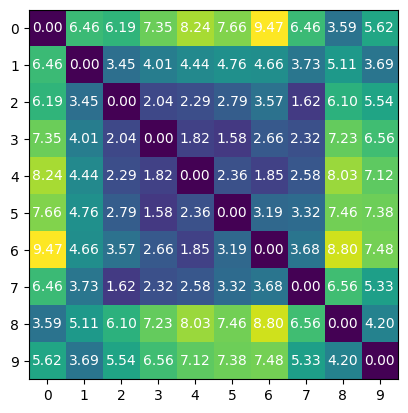

In [3]:
X_data = (training_data.data / 256).reshape(-1, 32*32*3)
mns = np.zeros((10, 32*32*3))
dists = np.zeros((10, 10))
for i in range(10):
    mns[i] = np.mean(X_data[np.array(training_data.targets) == i, :], axis=0)
for i in range(10):
    for j in range(10):
        dists[i][j] = np.linalg.norm(mns[i] - mns[j])

fig, ax = plt.subplots()
im = ax.imshow(dists)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))

for i in range(10):
    for j in range(10):
        text = ax.text(j, i, "%.2f" %(dists[i, j]),
                       ha="center", va="center", color="w")

In [4]:
in_channel = 3 # 1 if grayscale, 3 if full color
classes = [3, 4, 5]  # categories of consideration
num_class = len(classes)

In [5]:
# Extract data and normalize colors to [0, 1]
X_train_full = np.moveaxis(training_data.data / 256, -1, 1)
y_train_full = np.array(training_data.targets)
in_class_train = np.isin(y_train_full, classes)
X_train_full = torch.tensor(X_train_full[in_class_train], dtype=default_type, device=cuda)
y_train_full = y_train_full[in_class_train]
y_train_full = torch.tensor([classes.index(y) for y in y_train_full], device=cuda)

X_test_full = np.moveaxis(test_data.data / 256, -1, 1)
y_test_full = np.array(test_data.targets)
in_class_test = np.isin(y_test_full, classes)
X_test_full = torch.tensor(X_test_full[in_class_test], dtype=default_type, device=cuda)
y_test_full = y_test_full[in_class_test]
y_test_full = torch.tensor([classes.index(y) for y in y_test_full], device=cuda)

In [6]:
X_train_full.shape

torch.Size([15000, 3, 32, 32])

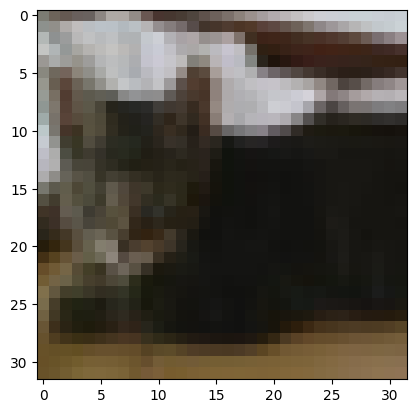

In [7]:
plt.imshow(np.moveaxis(X_train_full[1].cpu().numpy(), 0, -1))
plt.show()

In [8]:
# Generate minibatches for shuffling
n_sample = len(X_train_full)
batch_size = 128
X_train_split = torch.split(X_train_full, batch_size)
y_train_split = torch.split(y_train_full, batch_size)
Y_batch_split = tuple(map(lambda y_batch: torch.stack([torch.eye(num_class)[y] for y in y_batch]).to(cuda), y_train_split))
n_batch = len(y_train_split)

***
### Constructing the model

In [9]:
class cnn(nn.Module):
    def __init__(self, in_channel=1, num_class=3):
        super().__init__()
        self.C1_1 = nn.Conv2d(in_channels=in_channel, out_channels=16, kernel_size=3, padding=1)  # 16*32*32
        self.A1_1 = nn.ReLU()
        self.C1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)  # 16*32*32
        self.A1_2 = nn.ReLU()
        self.P1 = nn.MaxPool2d(kernel_size=2)  # 16*16*16

        self.C2_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # 32*16*16
        self.A2_1 = nn.ReLU()
        self.C2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # 32*16*16
        self.A2_2 = nn.ReLU()
        self.C2_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # 32*16*16
        self.A2_3 = nn.ReLU()
        self.P2 = nn.MaxPool2d(kernel_size=2)  # 32*8*8

        self.Flt = nn.Flatten()
        self.L3 = nn.Linear(in_features=2048, out_features=128)
        self.A3 = nn.ReLU()

        self.L4 = nn.Linear(in_features=128, out_features=num_class)
        self.A4 = nn.Tanh()

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x) :
        out = self.C1_1(x)
        out = self.A1_1(out)
        out = self.C1_2(out)
        out = self.A1_2(out)
        out = self.P1(out)

        out = self.C2_1(out)
        out = self.A2_1(out)
        out = self.C2_2(out)
        out = self.A2_2(out)
        out = self.C2_3(out)
        out = self.A2_3(out)
        out = self.P2(out)

        out = self.Flt(out)
        out = self.L3(out)
        out = self.A3(out)

        out = self.L4(out)
        # out = self.A4(out)

        return out

    def loss(self, x, y):
        pred = self.forward(x)
        return self.loss_fn(pred, y)


***
### Training

In [10]:
def get_accuracy(X_test, y_test, n_cat, model):
    test_pred = torch.argmax(F.forward(X_test), dim=1)
    correct = (test_pred == y_test).type(torch.float)
    acc = torch.mean(correct)
    cat_acc = [torch.mean(correct[y_test == c]).item() for c in range(n_cat)]
    return acc, cat_acc

In [11]:
epochs = 50
n_runs = 5
print_skip = 5 if (epochs >= 100) else 5
worst_acc_track = torch.zeros((n_runs, epochs//print_skip + 1))
loss_track = torch.zeros((n_runs, epochs//print_skip + 1))

verbose = True

In [12]:
for run in range(n_runs):
    print("--- Experiment #%2d ---\n" %(run+1))

    # Initialize NN and parameters
    F = cnn(in_channel, num_class).to(cuda)
    default_type = torch.get_default_dtype()
    theta = torch.rand(1, dtype=default_type, requires_grad=True, device=cuda)
    phi = torch.rand(1, dtype=default_type, requires_grad=True, device=cuda)
 
    min_grad_optim = torch.optim.Adam(F.parameters(), lr=0.002)
    max_grad_optim = torch.optim.Adam([theta, phi], lr=0.002, maximize=True)

    eta_k = lambda k: 1.0 / ((1 + 0.1*k)**0.34) 
    min_grad_sched = torch.optim.lr_scheduler.LambdaLR(min_grad_optim, eta_k)
    max_grad_sched = torch.optim.lr_scheduler.LambdaLR(max_grad_optim, eta_k)

    # Get info on the untrained NN
    pred = -torch.nn.functional.log_softmax(F.forward(X_train_split[0]), dim=1)
    cnt = torch.sum(Y_batch_split[0], dim=0)
    per_class_loss = torch.sum(pred * Y_batch_split[0], dim=0) / cnt
    z = torch.concat((torch.cos(theta),
                      torch.sin(theta)*torch.cos(phi),
                      torch.sin(theta)*torch.sin(phi)))
    x = z * z
    loss = torch.inner(per_class_loss, x)

    acc, class_acc = get_accuracy(X_test_full, y_test_full, num_class, F)
    worst_acc = min(class_acc)
    print("epoch %d : train loss %.4f with [%.4f, %.4f, %.4f],"
          %(0, loss.item(), per_class_loss[0], per_class_loss[1], per_class_loss[2]))
    print("\t\t test accuracy %.4f/%.4f with [%.4f, %.4f, %.4f]"
          %(worst_acc, acc, class_acc[0], class_acc[1], class_acc[2]))
    worst_acc_track[run, 0] = worst_acc
    loss_track[run, 0] = loss.item()

    for i in range(epochs):
        tau1 = torch.randperm(n_batch)
        tau2 = torch.randperm(n_batch)
        tau = torch.concat((tau1, tau2))

        # 2*n_batch for fair comparison
        for bb in range(2*n_batch):
            batch_idx = tau[bb]
            X_train_batch = X_train_split[batch_idx]
            y_train_batch = y_train_split[batch_idx]
            Y_batch = Y_batch_split[batch_idx]
            cnt = torch.sum(Y_batch, dim=0)

            ## Save parameters for gradient step
            min_params = []
            max_params = []
            for W in F.parameters():
                min_params.append(W.clone().detach())
            max_params.append(theta.clone().detach())
            max_params.append(phi.clone().detach())

            ## Extrapolation Step
            min_grad_optim.zero_grad()
            max_grad_optim.zero_grad()
            pred = -torch.nn.functional.log_softmax(F.forward(X_train_batch), dim=1)
            per_class_loss = torch.sum(pred * Y_batch, dim=0) / cnt

            z = torch.concat((torch.cos(theta),
                              torch.sin(theta)*torch.cos(phi),
                              torch.sin(theta)*torch.sin(phi)))
            x = z * z

            loss = torch.inner(per_class_loss, x)
            loss.backward()
            min_grad_optim.step()
            max_grad_optim.step()

            ## Gradient Step
            min_grad_optim.zero_grad()
            max_grad_optim.zero_grad()
            pred = -torch.nn.functional.log_softmax(F.forward(X_train_batch), dim=1)
            per_class_loss = torch.sum(pred * Y_batch, dim=0) / cnt

            z = torch.concat((torch.cos(theta),
                              torch.sin(theta)*torch.cos(phi),
                              torch.sin(theta)*torch.sin(phi)))
            x = z * z

            loss = torch.inner(per_class_loss, x)
            loss.backward()

            ### Recover parameters before taking a step
            for W0, W in zip(min_params, F.parameters()):
                W.data = W0.data
            theta.data = max_params[0].data
            phi.data = max_params[1].data

            min_grad_optim.step()
            max_grad_optim.step()

        # Stepsize decay 
        min_grad_sched.step()
        max_grad_sched.step()

        # Print out intermediate results
        if verbose and (i+1) % print_skip == 0 :
            acc, class_acc = get_accuracy(X_test_full, y_test_full, num_class, F)
            worst_acc = min(class_acc)
            print("epoch %d : lr = %.4f, train loss %.4f with [%.4f, %.4f, %.4f],"
                  %(i+1, min_grad_sched.get_last_lr()[0], loss.item(),
                    per_class_loss[0], per_class_loss[1], per_class_loss[2]))
            print("\t\t test accuracy %.4f/%.4f with [%.4f, %.4f, %.4f]"
                  %(worst_acc, acc, class_acc[0], class_acc[1], class_acc[2]))
            worst_acc_track[run, (i+1)//print_skip] = worst_acc
            loss_track[run, (i+1)//print_skip] = loss.item()

    # Print newline between runs
    print()

--- Experiment # 1 ---

epoch 0 : train loss 1.1002 with [1.0975, 1.1116, 1.0868],
		 test accuracy 0.0000/0.3333 with [0.0000, 0.0000, 1.0000]


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch 5 : lr = 0.0017, train loss 0.3769 with [0.3955, 0.3140, 0.3898],
		 test accuracy 0.7000/0.7570 with [0.7000, 0.8460, 0.7250]
epoch 10 : lr = 0.0016, train loss 0.0600 with [0.0292, 0.0963, 0.0642],
		 test accuracy 0.6470/0.7417 with [0.6470, 0.8220, 0.7560]
epoch 15 : lr = 0.0015, train loss 0.0022 with [0.0025, 0.0003, 0.0032],
		 test accuracy 0.6690/0.7467 with [0.6690, 0.8440, 0.7270]
epoch 20 : lr = 0.0014, train loss 0.0001 with [0.0001, 0.0002, 0.0000],
		 test accuracy 0.6740/0.7547 with [0.6740, 0.8490, 0.7410]
epoch 25 : lr = 0.0013, train loss 0.0000 with [0.0000, 0.0000, 0.0000],
		 test accuracy 0.6760/0.7520 with [0.6760, 0.8480, 0.7320]
epoch 30 : lr = 0.0012, train loss 0.0000 with [0.0000, 0.0000, 0.0000],
		 test accuracy 0.6880/0.7530 with [0.6880, 0.8450, 0.7260]
epoch 35 : lr = 0.0012, train loss 0.0000 with [0.0000, 0.0000, 0.0000],
		 test accuracy 0.6800/0.7540 with [0.6800, 0.8500, 0.7320]
epoch 40 : lr = 0.0012, train loss 0.0000 with [0.0000, 0.0000,

In [13]:
result_dir = "./results/"
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

np.save("./results/cifar_SEA_RR_results", worst_acc_track, allow_pickle=False)
np.save("./results/cifar_SEA_RR_losses", loss_track, allow_pickle=False)

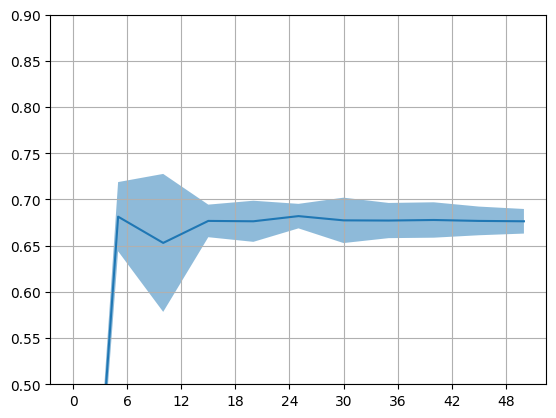

In [14]:
std, avg = torch.std_mean(worst_acc_track, dim=0, keepdim=False)
avg = avg.cpu().detach().numpy()
std = std.cpu().detach().numpy()
fig, ax = plt.subplots()
iters = np.arange(0, epochs+1, print_skip)
ax.plot(iters, avg)
ax.fill_between(iters, avg-2*std, avg+2*std, alpha=0.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylim(0.5, 0.9)
plt.grid(True)
plt.show()

In [15]:
ss = np.vstack((iters, worst_acc_track))
np.set_printoptions(linewidth=1000)
ss[:,10:]

array([[50.        ],
       [ 0.68000001],
       [ 0.66600001],
       [ 0.67400002],
       [ 0.68300003],
       [ 0.67900002]])